In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline

import matplotlib.style as style
style.use('seaborn-whitegrid')

import os
import pprint
# import googlemaps
# import time
import pickle
from random import randint
from collections import defaultdict, Counter

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import RidgeCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.naive_bayes import MultinomialNB
from sklearn.cluster import KMeans, MiniBatchKMeans

import nltk
from nltk.tokenize import word_tokenize, sent_tokenize, TreebankWordTokenizer, wordpunct_tokenize
from nltk.tag import pos_tag
from nltk.chunk import ne_chunk
from nltk.util import ngrams
from nltk.corpus import stopwords

from textblob import TextBlob

import string



In [3]:
import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()

In [4]:
# Set pandas options
pd.set_option('max_rows', 10)
# pd.set_option('max_colwidth', -1)
# pd.set_option('display.width', 150)
pd.set_option('display.max_rows', 10)
# pd.set_option('display.max_columns', None)

*Load the relevant data file*

In [5]:
!open .

In [11]:
# df = pd.read_csv('data/portland_reviews.csv', index_col=None)

df = pd.read_csv('data/cleaned_reviews.csv', index_col='Unnamed: 0')
# df = pd.read_csv('data/listing_descriptions.csv', index_col=0)
# df = pd.read_csv('data/cleaned_df.csv', index_col=None)

In [267]:
df.head()

,Unnamed: 0,id,host_id,host_listings_count,host_total_listings_count,neighbourhood,zipcode,latitude,longitude,property_type,...,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,reviews_per_month
0,0,7893,21489,1,1,Piedmont,97217,45.575479,-122.666777,House,...,2,100.0,10.0,10.0,10.0,10.0,10.0,10.0,0,0.02
1,1,12899,49682,1,1,Concordia,97211,45.564010,-122.634717,Guest suite,...,497,98.0,10.0,10.0,10.0,10.0,10.0,10.0,0,4.69
2,2,16688,64840,1,1,Pearl,97209,45.525418,-122.685566,House,...,40,97.0,10.0,10.0,10.0,10.0,10.0,9.0,1,2.27
3,3,25200,104038,6,6,Humboldt,97217,45.556750,-122.677839,House,...,33,92.0,9.0,9.0,10.0,10.0,10.0,9.0,0,0.32
4,4,26203,104038,6,6,Humboldt,97217,45.556965,-122.675656,House,...,27,92.0,9.0,10.0,9.0,10.0,10.0,9.0,0,0.27


In [265]:
summaries[0]

"Located on Williams bike corridor, some of Portland's best restaurants, bars and coffee shops are within a 5min drive and downtown is only 10min away.  Also features a wrap around patio with a covered awning to stay dry during the rainy season."

In [77]:
df.head(2)

,id,host_id,summary,space,description,neighborhood_overview,notes,host_about
0,7893,21489,"Located on Williams bike corridor, some of Por...",This NE Portland 2 bedroom home is located jus...,"Located on Williams bike corridor, some of Por...",NaN,NaN,"I love to cook, sail and play the mandolin ver..."
1,12899,49682,Settle in to a space of your own. You'll have ...,We live in a neighborhood of beautiful gardens...,Settle in to a space of your own. You'll have ...,We're within walking distance of a grocery and...,We welcome musicians and even have a guitar fo...,"We enjoy cooking, singing, hiking, bicycles, t..."


In [81]:
df.columns

Index(['id', 'host_id', 'summary', 'space', 'description',
       'neighborhood_overview', 'notes', 'host_about'],
      dtype='object')

In [92]:
# Fill NaNs with empty strings
for col in ['summary', 'space', 'description', 'neighborhood_overview', 'notes', 'host_about']:
    df[col].fillna('', inplace=True)


# Make sure there are not any null values remaining
df.head(2)

,id,host_id,summary,space,description,neighborhood_overview,notes,host_about
0,7893,21489,"Located on Williams bike corridor, some of Por...",This NE Portland 2 bedroom home is located jus...,"Located on Williams bike corridor, some of Por...",,,"I love to cook, sail and play the mandolin ver..."
1,12899,49682,Settle in to a space of your own. You'll have ...,We live in a neighborhood of beautiful gardens...,Settle in to a space of your own. You'll have ...,We're within walking distance of a grocery and...,We welcome musicians and even have a guitar fo...,"We enjoy cooking, singing, hiking, bicycles, t..."


In [244]:
descriptions = df['description']
about_host_text = df['host_about']
summaries = df['summary']
type(summaries)

pandas.core.series.Series

#### Remove punctuation, make lowercase, etc.

In [163]:
# Make lower case
summaries = summaries.apply(lambda x: x.lower())



In [164]:
summaries = pd.DataFrame(summaries)

In [165]:
# Remove punctuation
summaries['nopunc'] = summaries['summary'].str.replace('[^\w\s]','')

In [166]:
summaries

,summary,nopunc
0,"located on williams bike corridor, some of por...",located on williams bike corridor some of port...
1,settle in to a space of your own. you'll have ...,settle in to a space of your own youll have 2 ...
2,"newly remodeled 2 bedroom (3 queen beds), 2 fu...",newly remodeled 2 bedroom 3 queen beds 2 full ...
3,"if you are an urban farming pioneer, enthusias...",if you are an urban farming pioneer enthusiast...
4,"if you are an urban farming pioneer, enthusias...",if you are an urban farming pioneer enthusiast...
...,...,...
5400,moderate sized room with north garden and east...,moderate sized room with north garden and east...
5401,modern portland home with mid-century charm! t...,modern portland home with midcentury charm thi...
5402,1 bed 1 bath apartment living in ultra posh do...,1 bed 1 bath apartment living in ultra posh do...
5403,this is a cozy basement studio nestled on the ...,this is a cozy basement studio nestled on the ...


In [ ]:
# Tokenize by sentence
summaries['sent_tokenize'] = summaries['nopunc'].apply(lambda x: sent_tokenize(x))

In [153]:
# Tokenize by word
tokenizer = TreebankWordTokenizer()
summaries['word_tok'] = summaries['sent_tok'].apply(lambda x: [tokenizer.tokenize(y) for y in x])

In [ ]:
def get_count(item):
    return item[1]

for word, count in sorted(gatsby.word_counts.items(), key=get_count, reverse=True):
    print("%15s %i" % (word, count))

#### Feature Engineering - Polarity, subjectivity, length, sentence length, most frequent words

In [407]:
def get_sentiment(text):
    return TextBlob(text).sentiment[0]

def get_subjectivity(text):
    return TextBlob(text).sentiment[1]

In [810]:
df['polarity'] = df['comments'].apply(get_sentiment)
df['subjectivity'] = df['comments'].apply(get_subjectivity)

# Create column with character length of review
df['review_length'] = df['comments'].apply(len)

# Create column with the number of sentences per review
df['num_sentences'] = df['comments'].apply(lambda x: len(sent_tokenize(x)))

df['comment_words_only'] = df['comments'].apply(lambda x: re.sub('[^A-Za-z ]+', '', x.lower()))

# Create column with all individual words
df['individual_words'] = df['comment_words_only'].apply(lambda x: x.split(' '))

# Create column for word count
df['word_count'] = df['individual_words'].apply(len)

# Create column for the average length of words in each review
def get_avg_word_len(text):
    lengths = []
    for word in text:
        lengths.append(len(word))
    return sum(lengths) / len(lengths)

df['average_word_length'] = df['individual_words'].apply(get_avg_word_len)

In [824]:
# Get most frequent words
def get_most_frequent_words(text):
    words = Counter(text.split()).most_common(3)
    return [word for word in words if word[1] > 1]

df['most_frequent_words'] = df['cleaned_comments'].apply(get_most_frequent_words)

In [822]:
get_most_frequent_words(df['cleaned_comments'][16])

[('couldnt', 2)]

In [621]:
# Groupby listing ID, concat all reviews into one long string for getting most frequent words
pd.DataFrame(mini_df.groupby('listing_id')['reviews_cleaned_str'].agg(lambda x: ' '.join(x)))

,reviews_cleaned_str
listing_id,
12899,realli enjoy stay dave beauti home great neigh...
26203,excel first experi airbnb exactli expect descr...
37676,awesom place paul extrem friendli help great t...
39938,sarah host simpli incred home gorgeou street b...
41601,marbl room like time capsul mani littl thing d...
...,...
27631229,realli great easili access area check super ea...
28167575,realli nice time patricia place
28197448,great place stay nice part portland would defi...


In [623]:
Counter(comm['reviews_cleaned_str'][12899].split()).most_common(10)

[('great', 7),
 ('stay', 6),
 ('host', 6),
 ('like', 4),
 ('portland', 4),
 ('david', 4),
 ('time', 4),
 ('space', 4),
 ('definit', 4),
 ('home', 3)]

In [428]:
def process_text_no_stems(text):
    text = re.sub('[^A-Za-z ]+', '', text)
    text = text.lower().split()
    text = [word for word in text if ((len(word) > 3) and (word not in stop))]
    text = ' '.join(text)
    return text

In [429]:
process_text_no_stems(df['comments'][0])

'couldnt possibly better experience trip would give stars could thanks everything jesse condo fantastic'

In [430]:
df['cleaned_comments'] = df['comments'].apply(process_text_no_stems)

**Save DF to CSV**

In [829]:
# df.to_csv('data/cleaned_reviews.csv')

In [509]:
tokenizer = TreebankWordTokenizer()

def get_text_chunks(text):
    tags = pos_tag(word_tokenize(text))
    return [x for x in tags if x[1]=='NNP']

In [510]:
get_text_chunks(mini_df['comments'][0])

[('Ivy', 'NNP'), ('ANY', 'NNP'), ('Portland', 'NNP'), ('Ivy', 'NNP')]

In [483]:
pos_tag(df['comments'][1].split())

[("Jesse's", 'NNP'),
 ('place', 'NN'),
 ('was', 'VBD'),
 ('really', 'RB'),
 ('wonderful!', 'JJ'),
 ('The', 'DT'),
 ('apartment', 'NN'),
 ('is', 'VBZ'),
 ('located', 'VBN'),
 ('a', 'DT'),
 ('few', 'JJ'),
 ('blocks', 'NNS'),
 ('away', 'RB'),
 ('from', 'IN'),
 ('the', 'DT'),
 ('Alberta', 'NNP'),
 ('Arts', 'NNP'),
 ('district.', 'NN'),
 ('At', 'IN'),
 ('first', 'JJ'),
 ('it', 'PRP'),
 ('seems', 'VBZ'),
 ('like', 'IN'),
 ("it's", 'NN'),
 ('kind', 'NN'),
 ('of', 'IN'),
 ('deep', 'JJ'),
 ('but', 'CC'),
 ('once', 'RB'),
 ('you', 'PRP'),
 ('get', 'VB'),
 ('your', 'PRP$'),
 ('neighborhood', 'NN'),
 ('bearings', 'NNS'),
 ("you're", 'VBP'),
 ('like', 'IN'),
 ('oh', 'UH'),
 ('wow', 'NN'),
 ("here's", 'VBD'),
 ('a', 'DT'),
 ('bunch', 'NN'),
 ('of', 'IN'),
 ('rad', 'JJ'),
 ('stuff', 'NN'),
 ('just', 'RB'),
 ('a', 'DT'),
 ('few', 'JJ'),
 ('blocks', 'NNS'),
 ('away!', 'VBP'),
 ('And', 'CC'),
 ('oh', 'VBP'),
 ("what's", 'WRB'),
 ('that?', 'NN'),
 ('A', 'DT'),
 ('bunch', 'NN'),
 ('of', 'IN'),
 ('major', 

##### Create a mini dataframe of reviews to speed up processing time for testing (commented out and loaded from result)

In [23]:
# mini_df = df.sample(n=5000, replace=False, random_state=22)
# mini_df.reset_index(inplace=True)
# mini_df.to_csv('data/mini_reviews_df.csv')
mini_df = pd.read_csv('data/mini_reviews_df.csv', index_col='Unnamed: 0')

In [491]:
mini_df.head(2)

,index,listing_id,id,date,reviewer_id,reviewer_name,comments,reviews_cleaned_str,polarity,subjectivity,review_length,cleaned_comments
0,48257,1677299,98722579,2016-09-01,12555755,Shaun,Ivy was a wonderful host! She welcomed us with...,wonder host welcom surpris basket fuel rest we...,0.308333,0.725,296,wonderful host welcomed surprise basket fueled...
1,242359,15910855,307161783,2018-08-13,153332906,Matthew,"Great place to stay, would go back.",great place stay would back,0.400000,0.375,35,great place stay would back


In [493]:
mini_df.groupby('listing_id')['polarity'].mean()

listing_id
12899       0.435046
26203       0.257143
37676       0.438628
39938       0.467092
41601       0.439063
              ...   
27631229    0.628333
28167575    0.750000
28197448    0.466667
28226590    0.089167
28480171    0.347917
Name: polarity, Length: 2261, dtype: float64

#### Train-Test-Split

In [13]:
df.columns

Index(['listing_id', 'id', 'date', 'reviewer_id', 'reviewer_name', 'comments',
       'reviews_cleaned_str', 'polarity', 'subjectivity', 'review_length',
       'cleaned_comments', 'num_sentences', 'comment_words_only',
       'individual_words', 'word_count', 'average_word_length',
       'most_frequent_words'],
      dtype='object')

In [137]:
X = df[['listing_id', 'id', 'comments',
       'reviews_cleaned_str', 'polarity', 'subjectivity', 'review_length',
       'cleaned_comments', 'num_sentences', 'comment_words_only',
       'individual_words', 'word_count', 'average_word_length',
       'most_frequent_words']]

,listing_id,id,date,reviewer_id,reviewer_name,comments,reviews_cleaned_str,polarity,subjectivity,review_length,cleaned_comments,num_sentences,comment_words_only,individual_words,word_count,average_word_length,most_frequent_words
0,7893,27282,2010-02-22,52074,Shaun,Couldn't possibly had a better experience with...,couldnt possibl better experi trip would give ...,0.275,0.65,158,couldnt possibly better experience trip would ...,3,couldnt possibly had a better experience with ...,"['couldnt', 'possibly', 'had', 'a', 'better', ...",29,4.241379,[]


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=99)

In [138]:
test_df = df.sample(n=100000, replace=False, random_state=22)

#### Count Vectorizer, LDA

In [221]:
tf_vectorizer = CountVectorizer(max_df=0.5,
                                min_df=2,
                                lowercase=True,
                                strip_accents='unicode',
                                token_pattern = r'\b[a-zA-Z]{3,}\b',
                                stop_words='english', ngram_range=(1,2)
                               )
dtm_tf = tf_vectorizer.fit_transform(summaries)

In [207]:
dtm_tf.shape

(5405, 4706)

In [208]:
# for TF DTM
lda_tf = LatentDirichletAllocation(n_topics=10, random_state=0)
lda_tf.fit(dtm_tf)

# # for TFIDF DTM
# lda_tfidf = LatentDirichletAllocation(n_topics=20, random_state=0)
# lda_tfidf.fit(dtm_tfidf)

/Users/brenner/anaconda3/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='batch', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_components=10, n_jobs=None, n_topics=10, perp_tol=0.1,
             random_state=0, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)

In [209]:
pyLDAvis.sklearn.prepare(lda, dtm_tf, tf_vectorizer)

AssertionError: Topic-term distributions and document-term matrix have different number of columns, 1741 != 4706.

In [62]:
tf.shape

(5405, 5058)

In [66]:
vectorizer = TfidfVectorizer(stop_words="english", ngram_range=(1,2))
doc_vectors = vectorizer.fit_transform(summaries)

In [70]:
doc_vectors

<5405x89207 sparse matrix of type '<class 'numpy.float64'>'
	with 359635 stored elements in Compressed Sparse Row format>

In [201]:
lda_tf = LatentDirichletAllocation(n_components=10, max_iter=5,
                                learning_method='online',
                                learning_offset=10.0, batch_size=128,
                                random_state=49, evaluate_every=-1)
lda_tf.fit(tf)

In [464]:
vocab = tf_vectorizer.get_feature_names()

for topic in range(10):
    print(f"TOPIC {topic}")
    for j in np.argsort(-lda.components_,1)[topic,:10]:
        print(vocab[j])
    print()

NotFittedError: CountVectorizer - Vocabulary wasn't fitted.

In [260]:
def run_lda_with_defaults(corpus, num_topics):
    tf_vectorizer = CountVectorizer(lowercase=True,
                                    strip_accents='unicode',
                                    token_pattern = r'\b[a-zA-Z]{3,}\b',
                                    stop_words='english')
    
    dtm_tf = tf_vectorizer.fit_transform(corpus)
    
    lda_tf = LatentDirichletAllocation(n_components=num_topics, random_state=0, n_jobs=-1)
    lda_tf.fit(dtm_tf)
    
    return pyLDAvis.sklearn.prepare(lda_tf, dtm_tf, tf_vectorizer)

In [379]:
def run_lda(corpus, num_topics):
    tf_vectorizer = CountVectorizer(max_df=0.5,
                                    min_df=2,
                                    lowercase=True,
                                    strip_accents='unicode',
                                    token_pattern = r'\b[a-zA-Z]{3,}\b',
                                    stop_words='english')
    
    dtm_tf = tf_vectorizer.fit_transform(corpus)
    
    lda_tf = LatentDirichletAllocation(n_components=num_topics,
                                       random_state=0,
                                       learning_method='online',
                                       learning_decay=0.6,
                                       learning_offset=1024,
                                       batch_size=256,
                                       topic_word_prior=.005,
                                       n_jobs=-1)
    lda_tf.fit(dtm_tf)
    
    return pyLDAvis.sklearn.prepare(lda_tf, dtm_tf, tf_vectorizer)

In [255]:
def run_lda(corpus, num_topics):
    tf_vectorizer = CountVectorizer(max_df=0.5,
                                    min_df=2,
                                    lowercase=True,
                                    strip_accents='unicode',
                                    token_pattern = r'\b[a-zA-Z]{3,}\b',
                                    stop_words='english',
                                    ngram_range=(1,3))
    
    dtm_tf = tf_vectorizer.fit_transform(corpus)
    
    lda_tf = LatentDirichletAllocation(n_components=num_topics, random_state=0, learning_method='online', n_jobs=-1)
    lda_tf.fit(dtm_tf)
    
    return pyLDAvis.sklearn.prepare(lda_tf, dtm_tf, tf_vectorizer)

In [222]:
tf_vectorizer = CountVectorizer(strip_accents = 'unicode',
                                stop_words = 'english',
                                lowercase = True,
                                token_pattern = r'\b[a-zA-Z]{3,}\b',
                                max_df = 0.5, 
                                min_df = 10, ngram_range=(1,2))
dtm_tf = tf_vectorizer.fit_transform(summaries)
print(dtm_tf.shape)

(5405, 3766)


In [223]:
lda_tf = LatentDirichletAllocation(n_topics=10, random_state=0, learning_method='online', batch_size=1028)
lda_tf.fit(dtm_tf)

/Users/brenner/anaconda3/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


LatentDirichletAllocation(batch_size=1028, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='online', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_components=10, n_jobs=None, n_topics=10, perp_tol=0.1,
             random_state=0, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)

In [ ]:
pyLDAvis.sklearn.prepare(lda_tf, dtm_tf, tf_vectorizer)

In [259]:
run_lda_with_defaults(descriptions, 10)

/Users/brenner/anaconda3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5      0.069935  0.017552       1        1  24.356309
1      0.039434  0.069310       2        1  17.605827
0     -0.084185  0.154308       3        1  17.480405
6     -0.067826  0.070179       4        1  11.803181
9      0.036567  0.047240       5        1   9.663327
3      0.060626 -0.063598       6        1   6.518400
7      0.093458 -0.041467       7        1   4.518141
4     -0.000710  0.001390       8        1   3.071818
2     -0.252597 -0.130306       9        1   2.701773
8      0.105296 -0.124607      10        1   2.280819, topic_info=      Category         Freq         Term        Total  loglift  logprob
term                                                                   
9958   Default  5656.000000         room  5656.000000  30.0000  30.0000
486    Default  2556.000000    apartment  2556.000000  29.0000  29.0000
8338   Default  1774.000000         park  1774.000000  28.0000  28.0000
8870   Default  6697.000000     portland  6697.000000  27.0000  27.0000
1041   Default  3488.000000          bed  3488.000000  26.0000  26.0000
...        ...          ...          ...          ...      ...      ...
977    Topic10    53.709214     bathroom  2863.712166  -0.1957  -5.2560
5075   Topic10    51.609911        great  2288.945358  -0.0115  -5.2958
2384   Topic10    45.134626  comfortable  1644.301980   0.1852  -5.4299
10914  Topic10    42.105588     spacious  1079.955990   0.5361  -5.4994
7722   Topic10    42.159485         need  1299.012425   0.3527  -5.4981

[854 rows x 6 columns], token_table=       Topic      Freq        Term
term                              
23         1  0.046196  absolutely
23         2  0.027717  absolutely
23         4  0.083152  absolutely
23         6  0.674455  absolutely
23         8  0.129347  absolutely
...      ...       ...         ...
13157      8  0.898537        yurt
13164      2  0.061413         zen
13164      5  0.153533         zen
13164      7  0.706251         zen
13164      8  0.092120         zen

[2766 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 2, 1, 7, 10, 4, 8, 5, 3, 9])

#### Reviews Data

In [ ]:
df = pd.read_csv('data/portland_reviews.csv')

In [327]:
def replace_nans(column):
    return column.fillna('', inplace=True)

In [368]:
porter = nltk.stem.porter.PorterStemmer()
stop = stopwords.words('english')

# Remove punctuation and numerical characters
# Make lowercase and split on whitespace
# Stem words

def process_text(text):
    text = re.sub('[^A-Za-z ]+', '', text)
    text = text.lower().split()
    text = [word for word in text if ((len(word) > 3) and (word not in stop))]
    text = [porter.stem(word) for word in text]
    return text

In [360]:
reviews = df['comments']
reviews.fillna('', inplace=True)

In [369]:
reviews_cleaned = reviews.apply(process_text)

In [381]:
df['reviews_cleaned'] = reviews_cleaned

In [370]:
df.head(2)

,listing_id,id,date,reviewer_id,reviewer_name,comments,reviews_cleaned
0,7893,27282,2010-02-22,52074,Shaun,Couldn't possibly had a better experience with...,"[couldnt, possibl, better, experi, with, thi, ..."
1,7893,17461247,2014-08-12,13284006,Jessica,Jesse's place was really wonderful! The apartm...,"[jess, place, realli, wonder, apart, locat, bl..."


In [383]:
df['reviews_cleaned_str'] = df['reviews_cleaned'].str.join(' ')

In [385]:
# This took hours to run, so don't run it again!
# run_lda(df['reviews_cleaned_str'], 10)

/Users/brenner/anaconda3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.259342 -0.000381       1        1  25.273313
6      0.256205 -0.028770       2        1  23.432405
1      0.269568 -0.022171       3        1  19.474680
8      0.230163  0.040261       4        1  18.480893
4      0.077293  0.084852       5        1   6.036599
7     -0.204844 -0.171951       6        1   1.837004
0     -0.232364  0.174882       7        1   1.764435
3     -0.225582  0.242109       8        1   1.482658
5     -0.184048 -0.335532       9        1   1.168696
9     -0.245732  0.016702      10        1   1.049316, topic_info=      Category           Freq      Term          Total  loglift  logprob
term                                                                    
504    Default   29342.000000    airbnb   29342.000000  30.0000  30.0000
17998  Default  205576.000000     place  205576.000000  29.0000  29.0000
18354  Default  118439.000000  portland  118439.000000  28.0000  28.0000
25826  Default   59582.000000      walk   59582.000000  27.0000  27.0000
4066   Default   30688.000000     check   30688.000000  26.0000  26.0000
...        ...            ...       ...            ...      ...      ...
3754   Topic10     844.279575   carriag     844.339764   4.5570  -4.4600
4691   Topic10     810.599425     colin     810.659613   4.5570  -4.5007
12633  Topic10     737.041378     jessi     737.101567   4.5569  -4.5958
595    Topic10     686.940430      alan     687.000618   4.5569  -4.6662
7262   Topic10     682.393100     dylan     682.453289   4.5569  -4.6729

[538 rows x 6 columns], token_table=       Topic      Freq      Term
term                            
18         9  0.999633      abbi
100        1  0.112665    access
100        2  0.689867    access
100        4  0.197468    access
135        1  0.230053  accommod
...      ...       ...       ...
26724      1  0.255217      work
26724      2  0.093112      work
26724      3  0.116991      work
26724      4  0.534633      work
26926      7  0.999807      yoga

[820 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 7, 2, 9, 5, 8, 1, 4, 6, 10])

In [389]:
df.drop('reviews_cleaned', axis=1, inplace=True)

In [416]:
reviews_cleaned

0         [couldnt, possibl, better, experi, trip, would...
1         [jess, place, realli, wonder, apart, locat, bl...
2         [recommend, good, valu, spaciou, airi, upper, ...
3         [day, visit, portland, enorm, enhanc, alison, ...
4         [wonder, time, stay, area, alberta, artsth, be...
                                ...                        
318257    [moda, center, host, doug, quick, commun, rece...
318258               [feel, home, cozi, apart, great, view]
318259    [great, experi, hous, amen, requir, clean, eve...
318260    [thank, host, appreci, good, commun, highli, r...
318261    [elli, place, terrif, everyth, comfort, live, ...
Name: comments, Length: 318262, dtype: object

#### Fit-transform into matrix for further clustering

In [630]:
dtm_tf

<5405x3766 sparse matrix of type '<class 'numpy.int64'>'
	with 209291 stored elements in Compressed Sparse Row format>

In [651]:
vocab = tf_vectorizer.get_feature_names()

for topic in range(10):
    print(f"TOPIC {topic}")
    for j in np.argsort(-lda_tf.components_,1)[topic,:10]:
        print(vocab[j])
    print()

NotFittedError: CountVectorizer - Vocabulary wasn't fitted.

In [646]:
lda.perplexity(tf)

784.8127128854413

In [669]:
X = lda_tf.components_

In [671]:
X.shape

(10, 3766)

In [658]:
X = pd.Series(X)

In [661]:
km = KMeans(n_clusters=5)
km.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [663]:
km.inertia_

2537424.621555204

In [ ]:
tf_vectorizer = CountVectorizer(max_df=0.5,
                                    min_df=2,
                                    lowercase=True,
                                    strip_accents='unicode',
                                    token_pattern = r'\b[a-zA-Z]{3,}\b',
                                    stop_words='english')
    
    dtm_tf = tf_vectorizer.fit_transform(corpus)

In [674]:
#    tf_vectorizer = CountVectorizer(lowercase=True,
#                                     strip_accents='unicode',
#                                     token_pattern = r'\b[a-zA-Z]{3,}\b',
#                                     stop_words='english')
    
#     dtm_tf = tf_vectorizer.fit_transform(corpus)
    
lda_tf = LatentDirichletAllocation(n_components=10, random_state=0, n_jobs=-1)
lda_tf.fit_transform(dtm_tf)

array([[0.00400066, 0.59732322, 0.00400078, ..., 0.00400052, 0.00400141,
        0.00400078],
       [0.003031  , 0.19566205, 0.00303108, ..., 0.23809163, 0.00303088,
        0.00303104],
       [0.00156277, 0.54239545, 0.30493594, ..., 0.00156283, 0.00156287,
        0.00156284],
       ...,
       [0.00416731, 0.58501459, 0.00416734, ..., 0.0041683 , 0.38164438,
        0.00416804],
       [0.00178639, 0.00178604, 0.00178605, ..., 0.65630595, 0.00178619,
        0.00178613],
       [0.24495315, 0.00454613, 0.00454605, ..., 0.00454608, 0.00454696,
        0.30123185]])

In [684]:
# for topic in range(20):
#     print(f"TOPIC {topic}")
#     for j in np.argsort(-lda.components_,1)[topic,:10]:
#         print(vocab[j])
#     print()

TOPIC 0
place
great
business
travelers
close
couples
good
solo
adventurers
neighborhood

TOPIC 1
tabor
fun
outdoor
covered
backyard
scene
patio
fred
providence
serene

TOPIC 2
district
pearl
score
ceilings
loft
high
heart
steps
stay
bar

TOPIC 3
new
brand
experience
seasons
home
modern
designed
visit
school
guesthouse

TOPIC 4
north
friendly
people
welcome
live
kenton
light
friends
avenue
pets

TOPIC 5
room
private
bed
bedroom
queen
bathroom
kitchen
living
bath
space

TOPIC 6
coffee
fridge
tea
microwave
breakfast
mini
available
access
maker
use

TOPIC 7
alberta
apartment
arts
district
basement
located
house
home
blocks
studio

TOPIC 8
dryer
washer
house
tub
kitchen
unit
hot
enjoy
space
cozy

TOPIC 9
cute
square
sleeping
feet
nook
smoking
transport
backyard
cottage
inside

TOPIC 10
downtown
ohsu
available
waterfront
term
rental
rent
parking
south
near

TOPIC 11
home
stay
perfect
center
just
located
historic
neighborhood
space
away

TOPIC 12
views
forest
city
table
johns
deck
home
river


In [689]:
mini_df['reviews_cleaned_str']

0       wonder host welcom surpris basket fuel rest we...
1                             great place stay would back
2       trip portland made feel right home made trip m...
3       daniel joel place perfect stay week everyth ne...
4       locat quiet neighborhood spot walk distanc any...
                              ...                        
4995    place great locat close light rail didnt need ...
4996    area cute realli get steak whiley place commun...
4997    david gave wonder advic thing trip portland we...
4998    accommod hous felt like home truli comfort sta...
4999    cute effici feel like ikea catalog spread loca...
Name: reviews_cleaned_str, Length: 5000, dtype: object

In [25]:
tf_vectorizer = CountVectorizer(max_df=0.5,
                                    min_df=2,
                                    lowercase=True,
                                    strip_accents='unicode',
                                    token_pattern = r'\b[a-zA-Z]{3,}\b',
                                    stop_words='english')
    
dtm_tf = tf_vectorizer.fit_transform(mini_df['reviews_cleaned_str'])

ValueError: np.nan is an invalid document, expected byte or unicode string.

In [705]:
tf_vectorizer.get_feature_names()[:10]

['aanrad',
 'aaron',
 'abbi',
 'aber',
 'abil',
 'abl',
 'abod',
 'absenc',
 'absolut',
 'abund']

In [ ]:
lda_tf = LatentDirichletAllocation(n_components=num_topics,
                                       random_state=0,
                                       learning_method='online',
                                       learning_decay=0.6,
                                       learning_offset=1024,
                                       batch_size=256,
                                       topic_word_prior=.005,
                                       n_jobs=-1)
lda_tf.fit_transform(dtm_tf)

In [735]:
vec = CountVectorizer()
matrix = vec.fit_transform(mini_df['reviews_cleaned_str'])
pd.DataFrame(matrix.toarray(), columns=vec.get_feature_names())

,aankomst,aanrad,aanwezig,aaron,abbi,abe,aber,abil,abl,abnb,...,zipper,zitj,zoe,zona,zone,zonsondergang,zumindest,zumstein,zupan,zyrtec
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [722]:
km = MiniBatchKMeans(n_clusters=10)
km.fit(matrix)

MiniBatchKMeans(batch_size=100, compute_labels=True, init='k-means++',
        init_size=None, max_iter=100, max_no_improvement=10, n_clusters=10,
        n_init=3, random_state=None, reassignment_ratio=0.01, tol=0.0,
        verbose=0)

In [723]:
km.fit_transform(matrix)

array([[ 4.99851404,  4.60329207,  4.61497962, ...,  7.68114575,
         4.94085193,  8.71779789],
       [ 2.15436628,  2.52761297,  2.41927984, ...,  7.61577311,
         1.9648398 ,  7.41619849],
       [10.51036595,  9.99922075, 10.22069817, ..., 11.44552314,
        10.31318038, 11.83215957],
       ...,
       [ 5.50688993,  5.41164357,  5.41670747, ...,  8.83176087,
         5.44342136,  8.88819442],
       [ 3.7724262 ,  3.45334505,  3.57231739, ...,  7.48331477,
         3.64997291,  8.18535277],
       [ 9.89077418,  9.49124229,  9.71856347, ..., 11.48912529,
         9.75255026, 11.95826074]])

In [724]:
km.inertia_

130296.75856808036

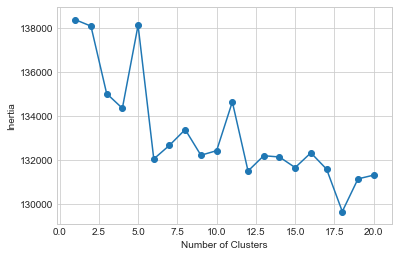

In [729]:
inertia = []
list_num_clusters = list(range(1,21))
for num_clusters in list_num_clusters:
    km = MiniBatchKMeans(n_clusters=num_clusters)
    km.fit(matrix)
    inertia.append(km.inertia_)
    
plt.plot(list_num_clusters,inertia)
plt.scatter(list_num_clusters,inertia)
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia');

In [730]:
# print(inertia)

[138372.08666666667, 138077.9732696004, 135011.2854062694, 134342.35315319823, 138116.5294270795, 132038.03966021142, 132660.12220458066, 133375.44334290357, 132207.39414966636, 132414.58396806827, 134633.49015832442, 131490.53814483777, 132185.67904331698, 132127.37076788655, 131646.04328747938, 132317.58229491062, 131574.30763594864, 129648.81514473732, 131132.92476470844, 131302.95814719322]


In [731]:
# print(list_num_clusters)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]


In [732]:
km = KMeans(n_clusters=6)
km.fit(matrix)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=6, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [733]:
km.fit_transform(matrix)

array([[ 4.79406547,  6.38974384,  4.97391943,  4.9913325 ,  5.30636337,
         4.53862143],
       [ 2.08799387,  5.31483123,  2.91575267,  1.83912464,  2.47940152,
         2.35067288],
       [10.30100097, 10.30312612,  9.83811822, 10.36013253, 10.33953496,
        10.25475618],
       ...,
       [ 5.46368891,  6.68500497,  5.40151796,  5.38647695,  5.7937859 ,
         5.6725343 ],
       [ 3.49917061,  5.60655666,  3.78886878,  3.76991592,  4.22297864,
         3.10817606],
       [ 9.7088126 ,  9.97279968,  9.53897523,  9.77485668,  9.81286406,
         9.42790688]])

In [766]:
for i in km.cluster_centers_:
    print(i.max())

0.36101083032490977
2.046511627906977
0.7565217391304347
1.3455637091394264
2.3601609657947686
2.013215859030837


In [739]:
mini_df['cluster_pred'] = km.predict(matrix)

In [832]:
for i in range (0, 6):
    print(f'\nCluster #{i}:\n')
    print(mini_df[mini_df['cluster_pred']==i]['comments'][:11].values)


Cluster #0:

["Located in a quiet neighborhood, this spot is walking distance from anything you need, and short Lyft's from anything you want. Perfect for a weekend visit to Portland!"
 "Jeni's place was perfect for my weekend getaway.  Very convenient location.  Jeni was very easy to work with.  Place was nice.  "
 'Amazing house in an awesome neighborhood! Everything about our stay was perfect! Highly recommended!.'
 'Awesome little house & awesome hosts. Lots of thoughtful touches easy peasy checkin.'
 'Callie covered every detail to insure our comfort. The bed was comfy and the adjoining bath spotless. Be aware the property is near the top of a short but very steep hill, not appropriate for those with mobility issues. The neighborhood is lovely and safe. We especially enjoyed walking the scenic paths along the nearby  river.'
 'Awesome location, semi private room shared with acupuncture space. Host was very flexible about check in and check out '
 'The location of this place was i

In [755]:
mini_df.columns

Index(['index', 'listing_id', 'id', 'date', 'reviewer_id', 'reviewer_name',
       'comments', 'reviews_cleaned_str', 'polarity', 'subjectivity',
       'review_length', 'cleaned_comments', 'cluster_pred'],
      dtype='object')

In [781]:
mini_df.groupby('cluster_pred').mean()

,index,listing_id,id,reviewer_id,polarity,subjectivity,review_length,num_sentences
cluster_pred,,,,,,,,
0,170988.483755,1.067775e+07,1.834945e+08,6.358497e+07,0.378962,0.626172,179.386282,3.131167
1,139032.558140,8.433975e+06,1.386277e+08,3.843336e+07,0.333045,0.572869,1277.627907,13.662791
2,144363.229565,8.659678e+06,1.487984e+08,4.520289e+07,0.358610,0.605424,540.780870,6.760000
3,168834.026017,1.054570e+07,1.826870e+08,5.842258e+07,0.510836,0.661042,191.773182,3.418279
4,165790.394366,1.037835e+07,1.760991e+08,5.553882e+07,0.389078,0.625418,405.977867,5.563380
5,148415.027900,8.959630e+06,1.535050e+08,4.748164e+07,0.375847,0.621449,387.023495,5.444934


In [780]:
mini_df.groupby('listing_id').mean()

,index,id,reviewer_id,polarity,subjectivity,review_length,cluster_pred,num_sentences
listing_id,,,,,,,,
12899,208.000000,4.172736e+07,8.117452e+06,0.435046,0.644374,351.500000,1.875000,4.250000
26203,575.000000,2.220860e+05,4.503810e+05,0.257143,0.469048,260.000000,0.000000,4.000000
37676,699.000000,6.864086e+06,1.910440e+06,0.438628,0.577965,560.000000,3.000000,8.333333
39938,853.333333,1.154776e+08,2.371007e+07,0.467092,0.590487,395.666667,2.333333,6.333333
41601,1031.500000,1.846395e+05,3.233805e+05,0.439063,0.690972,155.000000,0.000000,2.000000
...,...,...,...,...,...,...,...,...
27631229,317741.000000,3.257698e+08,1.917696e+08,0.628333,0.675000,102.000000,3.000000,4.000000
28167575,318115.000000,3.274645e+08,2.164211e+08,0.750000,1.000000,46.000000,0.000000,1.000000
28197448,318125.000000,3.216481e+08,6.662344e+07,0.466667,0.783333,143.000000,5.000000,3.000000


In [779]:
mini_df.describe()

,index,listing_id,id,reviewer_id,polarity,subjectivity,review_length,cluster_pred,num_sentences
count,5000.000000,5.000000e+03,5.000000e+03,5.000000e+03,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,163139.836400,1.010372e+07,1.736710e+08,5.649768e+07,0.415949,0.632605,294.353400,2.225200,4.372600
std,92511.502449,7.267730e+06,9.551488e+07,5.392084e+07,0.187234,0.153816,249.195646,1.794416,2.764507
min,16.000000,1.289900e+04,7.141800e+04,1.000000e+00,-0.750000,0.000000,0.000000,0.000000,0.000000
25%,82410.500000,3.761821e+06,9.029888e+07,1.327119e+07,0.303901,0.556582,132.000000,0.000000,3.000000
50%,165305.000000,8.714815e+06,1.740933e+08,3.680000e+07,0.401220,0.635714,236.500000,3.000000,4.000000
75%,244618.750000,1.605875e+07,2.601940e+08,8.763617e+07,0.516938,0.725000,387.250000,3.000000,6.000000
max,318210.000000,2.848017e+07,3.343601e+08,2.173200e+08,1.000000,1.000000,2886.000000,5.000000,35.000000


In [778]:
mini_df['num_sentences'] = mini_df['comments'].apply(lambda x: len(sent_tokenize(x)))

In [830]:
mini_df['cluster_pred'].value_counts()

0    1662
3    1499
5     681
2     575
4     497
1      86
Name: cluster_pred, dtype: int64

#### New workflow

In [135]:
df.head(2)

,listing_id,id,date,reviewer_id,reviewer_name,comments,reviews_cleaned_str,polarity,subjectivity,review_length,cleaned_comments,num_sentences,comment_words_only,individual_words,word_count,average_word_length,most_frequent_words
0,7893,27282,2010-02-22,52074,Shaun,Couldn't possibly had a better experience with...,couldnt possibl better experi trip would give ...,0.275000,0.650000,158,couldnt possibly better experience trip would ...,3,couldnt possibly had a better experience with ...,"['couldnt', 'possibly', 'had', 'a', 'better', ...",29,4.241379,[]
1,7893,17461247,2014-08-12,13284006,Jessica,Jesse's place was really wonderful! The apartm...,jess place realli wonder apart locat block awa...,0.275463,0.601852,670,jesses place really wonderful apartment locate...,10,jesses place was really wonderful the apartmen...,"['jesses', 'place', 'was', 'really', 'wonderfu...",119,4.436975,"[('place', 2), ('really', 2), ('apartment', 2)]"


In [136]:
mini_df.head(2)

,index,listing_id,id,date,reviewer_id,reviewer_name,comments,reviews_cleaned_str,polarity,subjectivity,review_length,cleaned_comments
0,48257,1677299,98722579,2016-09-01,12555755,Shaun,Ivy was a wonderful host! She welcomed us with...,wonder host welcom surpris basket fuel rest we...,0.308333,0.725,296,wonderful host welcomed surprise basket fueled...
1,242359,15910855,307161783,2018-08-13,153332906,Matthew,"Great place to stay, would go back.",great place stay would back,0.400000,0.375,35,great place stay would back


In [ ]:
mini_df = df.sample(n=5000, replace=False, random_state=22)

In [140]:
mini_df['cleaned_comments'].fillna('', inplace=True)

In [82]:
def run_new_lda(corpus, topics):
    tf_vectorizer = CountVectorizer(max_df=0.95,
                                    min_df=2,
                                    lowercase=True,
                                    strip_accents='unicode',
                                    token_pattern = r'\b[a-zA-Z]{3,}\b',
                                    stop_words='english')

    dtm_tf = tf_vectorizer.fit_transform(corpus)

    vocab = np.array(tf_vectorizer.get_feature_names())
    counts = np.array(dtm_tf.sum(0))[0,:]
    vocab[np.argsort(-counts)[:100]]

    lda_tf = LatentDirichletAllocation(n_components=topics,
                                       random_state=0,
                                       learning_method='online',
                                       learning_decay=0.6,
                                       learning_offset=1024,
                                       batch_size=256,
                                       topic_word_prior=.005,
                                       n_jobs=-1)
    lda_tf.fit(dtm_tf) #or fit_transform
    
    return dtm_tf, vocab, counts, lda_tf

In [71]:
lda_tf.perplexity(dtm_tf)

1874.0727072615089

In [132]:
# pyLDAvis.sklearn.prepare(lda_tf, dtm_tf, tf_vectorizer)
pyLDAvis.sklearn.prepare(lda_tf, dtm_tf, tf_vectorizer, mds='mmds')

/Users/brenner/anaconda3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7      0.173815  0.138753       1        1  96.510767
11     0.036277 -0.094075       2        1   0.341393
16    -0.071236 -0.031937       3        1   0.306807
12    -0.029988  0.045204       4        1   0.261717
10     0.035750 -0.010454       5        1   0.255948
...         ...       ...     ...      ...        ...
9     -0.010802 -0.002696      16        1   0.151012
4     -0.010289 -0.003989      17        1   0.151012
3     -0.011489 -0.003667      18        1   0.151012
17    -0.009889 -0.003791      19        1   0.151012
0     -0.009587 -0.003716      20        1   0.151012

[20 rows x 5 columns], topic_info=      Category         Freq              Term        Total  loglift  logprob
term                                                                        
6493   Default   829.000000              host   829.000000  30.0000  30.0000
13605  Default   602.000000             super   602.000000  29.0000  29.0000
4042   Default   505.000000          downtown   505.000000  28.0000  28.0000
2307   Default  1400.000000             clean  1400.000000  27.0000  27.0000
11892  Default   714.000000              room   714.000000  26.0000  26.0000
...        ...          ...               ...          ...      ...      ...
9073   Topic20     0.020561      neighborhood   915.607546  -4.2084  -9.3407
9908   Topic20     0.020392           perfect   806.223401  -4.0894  -9.3490
2148   Topic20     0.020366           checked    42.499540  -1.1478  -9.3502
9960   Topic20     0.020366  perfect location    76.352230  -1.7337  -9.3503
10922  Topic20     0.020229          products    13.516311  -0.0090  -9.3570

[1499 rows x 6 columns], token_table=       Topic      Freq         Term
term                               
0          5  0.898871     aanrader
5          3  0.646296         aber
14         1  0.904820    able cook
42         1  0.996112   absolutely
76         1  0.588585  access door
...      ...       ...          ...
15418      3  0.631665         wrde
15419      3  0.818107        wrden
15428      1  0.966823    yard area
15482      1  0.994684        youve
15492      3  0.527536       zimmer

[827 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[8, 12, 17, 13, 11, 2, 3, 6, 7, 9, 14, 19, 16, 15, 20, 10, 5, 4, 18, 1])

In [97]:
def run_new_lda(corpus, topics):
    tf_vectorizer = CountVectorizer(max_df=0.95,
                                min_df=2,
                                lowercase=True,
                                strip_accents='unicode',
                                token_pattern = r'\b[a-zA-Z]{3,}\b',
                                stop_words='english')
    
    dtm_tf = tf_vectorizer.fit_transform(corpus)

    vocab = np.array(tf_vectorizer.get_feature_names())
    counts = np.array(dtm_tf.sum(0))[0,:]
    vocab[np.argsort(-counts)[:100]]

    lda_tf = LatentDirichletAllocation(n_components=topics,
                                       random_state=0,
                                       learning_method='online',
                                       learning_decay=0.6,
                                       learning_offset=1024,
                                       batch_size=256,
                                       topic_word_prior=.005,
                                       n_jobs=-1)
    lda_tf.fit(dtm_tf) #or fit_transform

In [98]:
run_new_lda(mini_df['cleaned_comments'], 6)

CURRENT

In [143]:
tf_vectorizer = CountVectorizer(
                            max_df=0.3,
                            min_df=2,
                            lowercase=True,
                            strip_accents='unicode',
                            token_pattern = r'\b[a-zA-Z]{3,}\b',
                            stop_words='english',
                            ngram_range=(1,2))

dtm_tf = tf_vectorizer.fit_transform(mini_df['cleaned_comments'])

vocab = np.array(tf_vectorizer.get_feature_names())
counts = np.array(dtm_tf.sum(0))[0,:]
vocab[np.argsort(-counts)[:100]]

lda_tf = LatentDirichletAllocation(n_components=10,
                                   random_state=0,
                                   learning_method='online',
                                   learning_decay=0.6,
                                   learning_offset=1024,
                                   batch_size=256,
                                   topic_word_prior=.005,
                                   n_jobs=-1)
lda_tf.fit(dtm_tf) #or fit_transform

LatentDirichletAllocation(batch_size=256, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.6,
             learning_method='online', learning_offset=1024,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_components=10, n_jobs=-1, n_topics=None, perp_tol=0.1,
             random_state=0, topic_word_prior=0.005,
             total_samples=1000000.0, verbose=0)

In [144]:
lda_tf.perplexity(dtm_tf)

23907.926531769088

In [146]:
for topic in range(10):
    print(f"TOPIC {topic}")
    for j in np.argsort(-lda_tf.components_,1)[topic,:10]:
        print(vocab[j])
    print()

TOPIC 0
safe comfortable
frills
honest
anne
thumbs
ahead
straight
rachel
comfortable
beautiful

TOPIC 1
little
private
didnt
came
experience
location
cozy
restaurants
arthaus
comfortable

TOPIC 2
toney
toney mimis
mimis place
mimis
musical instruments
instruments
musical
snacks toiletries
available guests
stay extra

TOPIC 3
amis place
amis
glad
says
easy
check
comfortable
recommend
room
super

TOPIC 4
nous
dans
pour
nous avons
avons
pass
maison
quartier
sjour
agrable

TOPIC 5
connor
communicative leading
location thank
advice area
leading stay
area excellent
stay offered
leading
great advice
house

TOPIC 6
sehr
haus
eine
haben
sauber
schn
super
kann
alles
unterkunft

TOPIC 7
clean
location
house
comfortable
home
space
nice
neighborhood
easy
recommend

TOPIC 8
reservation
canceled
posting
arrival
arrival automated
automated posting
automated
canceled reservation
host
host canceled

TOPIC 9
casa
nuestra
tranquilo
centro
habitacin
cerca
camera
ubicacin
buena
washington park



In [113]:
# lda_tf.fit_transform(dtm_tf)

array([[0.00238095, 0.00238095, 0.00238095, ..., 0.00238095, 0.00238095,
        0.00238095],
       [0.0125    , 0.0125    , 0.0125    , ..., 0.0125    , 0.0125    ,
        0.0125    ],
       [0.00072464, 0.00072464, 0.00072464, ..., 0.00072464, 0.00072464,
        0.00072464],
       ...,
       [0.00263158, 0.00263158, 0.00263158, ..., 0.00263158, 0.00263158,
        0.00263158],
       [0.00384615, 0.00384615, 0.00384615, ..., 0.00384615, 0.00384615,
        0.00384615],
       [0.00086207, 0.00086207, 0.00086207, ..., 0.00086207, 0.00086207,
        0.00086207]])

In [ ]:
new = lda_tf.transform(dtm_tf)

In [ ]:
new.shape

In [142]:
df.shape

(318262, 17)

In [147]:
pyLDAvis.sklearn.prepare(lda_tf, dtm_tf, tf_vectorizer, mds='tsne')

/Users/brenner/anaconda3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
7     -216.353119  453.817749       1        1  96.771644
8      -88.538757  139.208084       2        1   0.484774
6     -374.347748 -340.132324       3        1   0.465770
4      533.486206  113.960625       4        1   0.418148
2      214.243164   -3.341710       5        1   0.319229
9      382.970276 -315.597412       6        1   0.316616
5       43.623711 -524.937927       7        1   0.309553
0     -435.401794   55.724300       8        1   0.307011
3      207.386719  387.299072       9        1   0.305231
1      -60.650341 -194.592575      10        1   0.302023, topic_info=      Category        Freq              Term        Total  loglift  logprob
term                                                                       
6493   Default  834.000000              host   834.000000  30.0000  30.0000
13605  Default  605.000000             super   605.000000  29.0000  29.0000
4042   Default  506.000000          downtown   506.000000  28.0000  28.0000
639    Default  539.000000         apartment   539.000000  27.0000  27.0000
884    Default  123.000000           arrival   123.000000  26.0000  26.0000
...        ...         ...               ...          ...      ...      ...
6705   Topic10    0.046488             house  1203.722125  -4.3593  -9.2180
14894  Topic10    0.045674  walking distance   355.149843  -3.1564  -9.2357
5412   Topic10    0.045588              gave   170.750475  -2.4259  -9.2376
5257   Topic10    0.044994          friendly   405.588596  -3.3041  -9.2507
9908   Topic10    0.044918           perfect   807.475785  -3.9944  -9.2524

[643 rows x 6 columns], token_table=       Topic      Freq                     Term
term                                           
0          2  0.614801                 aanrader
5          3  0.948816                     aber
8          1  0.997387                     able
279        1  0.620683              advice area
298        4  0.757575                  agrable
...      ...       ...                      ...
15287      1  0.960535  wonderful accommodating
15363      1  0.539762                 woodwork
15418      3  0.934263                     wrde
15419      3  0.614906                    wrden
15492      3  0.769510                   zimmer

[466 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[8, 9, 7, 5, 3, 10, 6, 1, 4, 2])